In [82]:
import pandas as pd
from pathlib import Path
import pgeon.policy_graph as PG
from example.environment import SelfDrivingEnvironment
from nuscenes import NuScenes
import numpy as np
from matplotlib.patches import Rectangle

from nuscenes.map_expansion.map_api import NuScenesMap, NuScenesMapExplorer
from nuscenes.map_expansion import arcline_path_utils
import math
from typing import Tuple

In [2]:
#path where you stored the copy of the nuScenes dataset.
DATAROOT = Path('/home/saramontese/Desktop/MasterThesis/example/dataset/data/sets/nuscenes')

#MINI
nuscenes = NuScenes('v1.0-mini', dataroot=DATAROOT)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.458 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [3]:

dtype_dict = {
    'modality': 'category',  # for limited set of modalities, 'category' is efficient
    'scene_token': 'str',  
    'timestamp': 'str',  # To enable datetime operations
    'rotation': 'object',  # Quaternion (lists)
    'x': 'float64',
    'y': 'float64',
    'z': 'float64',
    'yaw': 'float64',  
    'velocity': 'float64',
    'acceleration': 'float64',
    'heading_change_rate': 'float64',
    'delta_local_x': 'float64',
    'delta_local_y': 'float64'}
df = pd.read_csv(DATAROOT / 'train_v1.0-mini_lidar_0.csv', dtype=dtype_dict, parse_dates=['timestamp'])
#df['detect_CAM_FRONT'] = df['detect_CAM_FRONT'].apply(lambda x: ast.literal_eval(x))
#df['detect_CAM_BACK'] = df['detect_CAM_BACK'].apply(lambda x: ast.literal_eval(x))
city = 'boston-seaport' #'singapore-hollandvillage'
df = df[df['location'] == city]
df.head()

,scene_token,steering_angle,location,modality,timestamp,rotation,x,y,z,yaw,velocity,acceleration,yaw_rate,delta_local_x,delta_local_y
0,2fc3753772e241f2ab2cd16a784cc680,-0.202386,boston-seaport,lidar,2018-08-30 19:25:09.301132,"[-0.1557237496690409, 0.011222825001502285, 0....",329.647494,660.196689,0.0,2.828707,5.108550,-0.034804,-0.045330,0.000000,0.000000
1,2fc3753772e241f2ab2cd16a784cc680,-0.125592,boston-seaport,lidar,2018-08-30 19:25:09.801064,"[-0.16117694469754024, 0.009157178788916257, 0...",327.233834,661.025514,0.0,2.817706,5.104695,-0.007711,-0.022006,0.045648,2.551592
2,2fc3753772e241f2ab2cd16a784cc680,-0.410080,boston-seaport,lidar,2018-08-30 19:25:10.651414,"[-0.16605361559690043, 0.007585584174464603, -...",323.362925,662.405363,0.0,2.807968,4.709219,-0.583132,-0.017080,0.076174,4.108786
3,2fc3753772e241f2ab2cd16a784cc680,-0.591595,boston-seaport,lidar,2018-08-30 19:25:11.149672,"[-0.1790782272855317, 0.009448521999393368, -0...",321.358449,663.164911,0.0,2.781689,4.302103,-0.817080,-0.052741,0.061262,2.142681
4,2fc3753772e241f2ab2cd16a784cc680,-0.256491,boston-seaport,lidar,2018-08-30 19:25:11.649009,"[-0.19383694099663118, 0.006067266248244902, -...",319.518145,663.938454,0.0,2.751458,3.997839,-0.609336,-0.060543,0.075857,1.994827


In [4]:
nusc_map = NuScenesMap(dataroot='example/dataset/data/sets/nuscenes', map_name = city)
nusc_exp = NuScenesMapExplorer(nusc_map)

In [6]:
def get_lane_position(x,y):
        """
        Returns Left, Right or Center based on the car position. Left if on the left lane of the road, RIGHT is right and Center if in the 
        center.

        """

        #we suppose drivers stay on the right. 
        #1. check if has a road divider on the left. If yes: right

        #2. check if has a road divider on the right. If yes: left
        #3. check if ego vehicle is on road divider. If yes: center
        #4. right

        road_divider = nusc_map.record_on_point(x,y, 'road_divider')
        print('Road objects on selected point:', nusc_map.layers_on_point(x, y), '\n')

        if road_divider:
                return 1#LanePosition.CENTER
        else:
                return 0#LanePosition.RIGHT
        

In [85]:
records = getattr(nusc_exp.map_api, 'road_divider')
        
def is_on_divider(x,y, yaw, agent_size:Tuple[float, float], layer_name: str) -> bool:
        """
        Retrieve the lines of a particular layer within the specified patch.
        :param x,y,yaw: coordinates (in meters) and heading (in radians) of the agent 
        :param agent_size: height and width of the box representing the agent
        :param layer_name: name of map layer to be converted to binary map mask patch.
        :return: True if agent intersects the layers specified in layer_name
        """
        #for visual confirmation
        patch_size = 40
        patch_box = [x,y, patch_size, patch_size]
        patch = nusc_exp.get_patch_coord(patch_box)
        minx, miny, maxx, maxy = patch.bounds

        fig, ax = nusc_map.render_map_patch( [minx, miny, maxx, maxy], ['road_divider', 'lane_divider'], figsize=(10, 10))
        ax.add_patch(Rectangle((x,y), agent_size[0], agent_size[1], yaw))


        for record in records:
            line = nusc_exp.map_api.extract_line(record['line_token'])
            if line.is_empty:  # Skip lines without nodes.
                continue

            new_line = patch.intersection(line)
            if not new_line.is_empty:
                return True

        return False

Render

In [ ]:
nuscenes.render_scene(scene_test)

In [ ]:
scene_test = df['scene_token'].unique()[3]
example_scene_df = df[df['scene_token']==scene_test]
ego_poses = nusc_map.render_egoposes_on_fancy_map(nuscenes, scene_tokens=[scene_test], verbose=False)
#nuscenes.render_scene(scene_test)

Test progress discretization

TypeError: 'float' object is not subscriptable

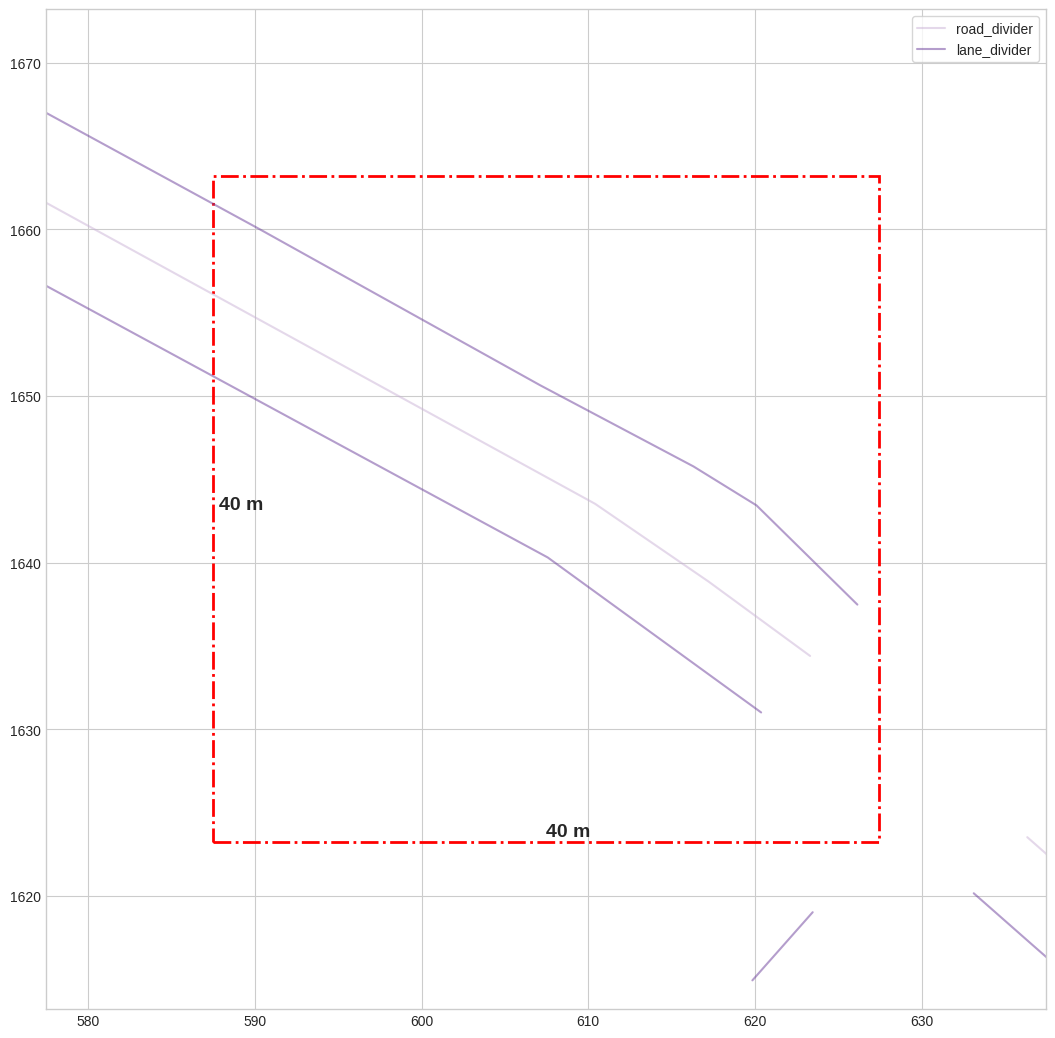

In [87]:

for i in range(example_scene_df.shape[0]):
    x,y,yaw = example_scene_df.iloc[i][['x','y', 'yaw']].tolist()
    #my_patch = [x-1, y-2, x+1, y+2]
    
    #fig, ax = nusc_map.render_map_patch( my_patch, ['road_divider', 'lane_divider'], figsize=(5, 5))

    
    #records_within_patch = nusc_map.get_records_in_patch(my_patch, ['road_divider', 'lane_divider'], mode='within')
    #records_intersect_patch = nusc_map.get_records_in_patch(my_patch, ['road_divider', 'lane_divider'], mode='intersect')
    #print(f'records_within_patch:{records_within_patch}')
    #print(f'records_intersect_patch:{records_intersect_patch}')
  
    #break
    yaw =  math.degrees(-(math.pi / 2) + yaw)

    print(is_on_divider(x,y,(3,5),yaw, ['road_divider', 'lane_divider']))
    break


Test Rotation (patch angle)

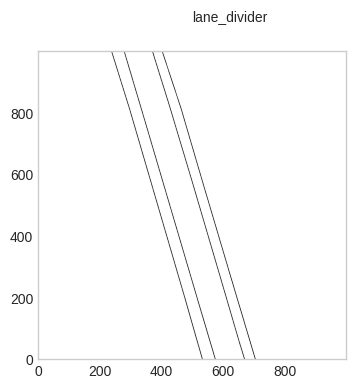

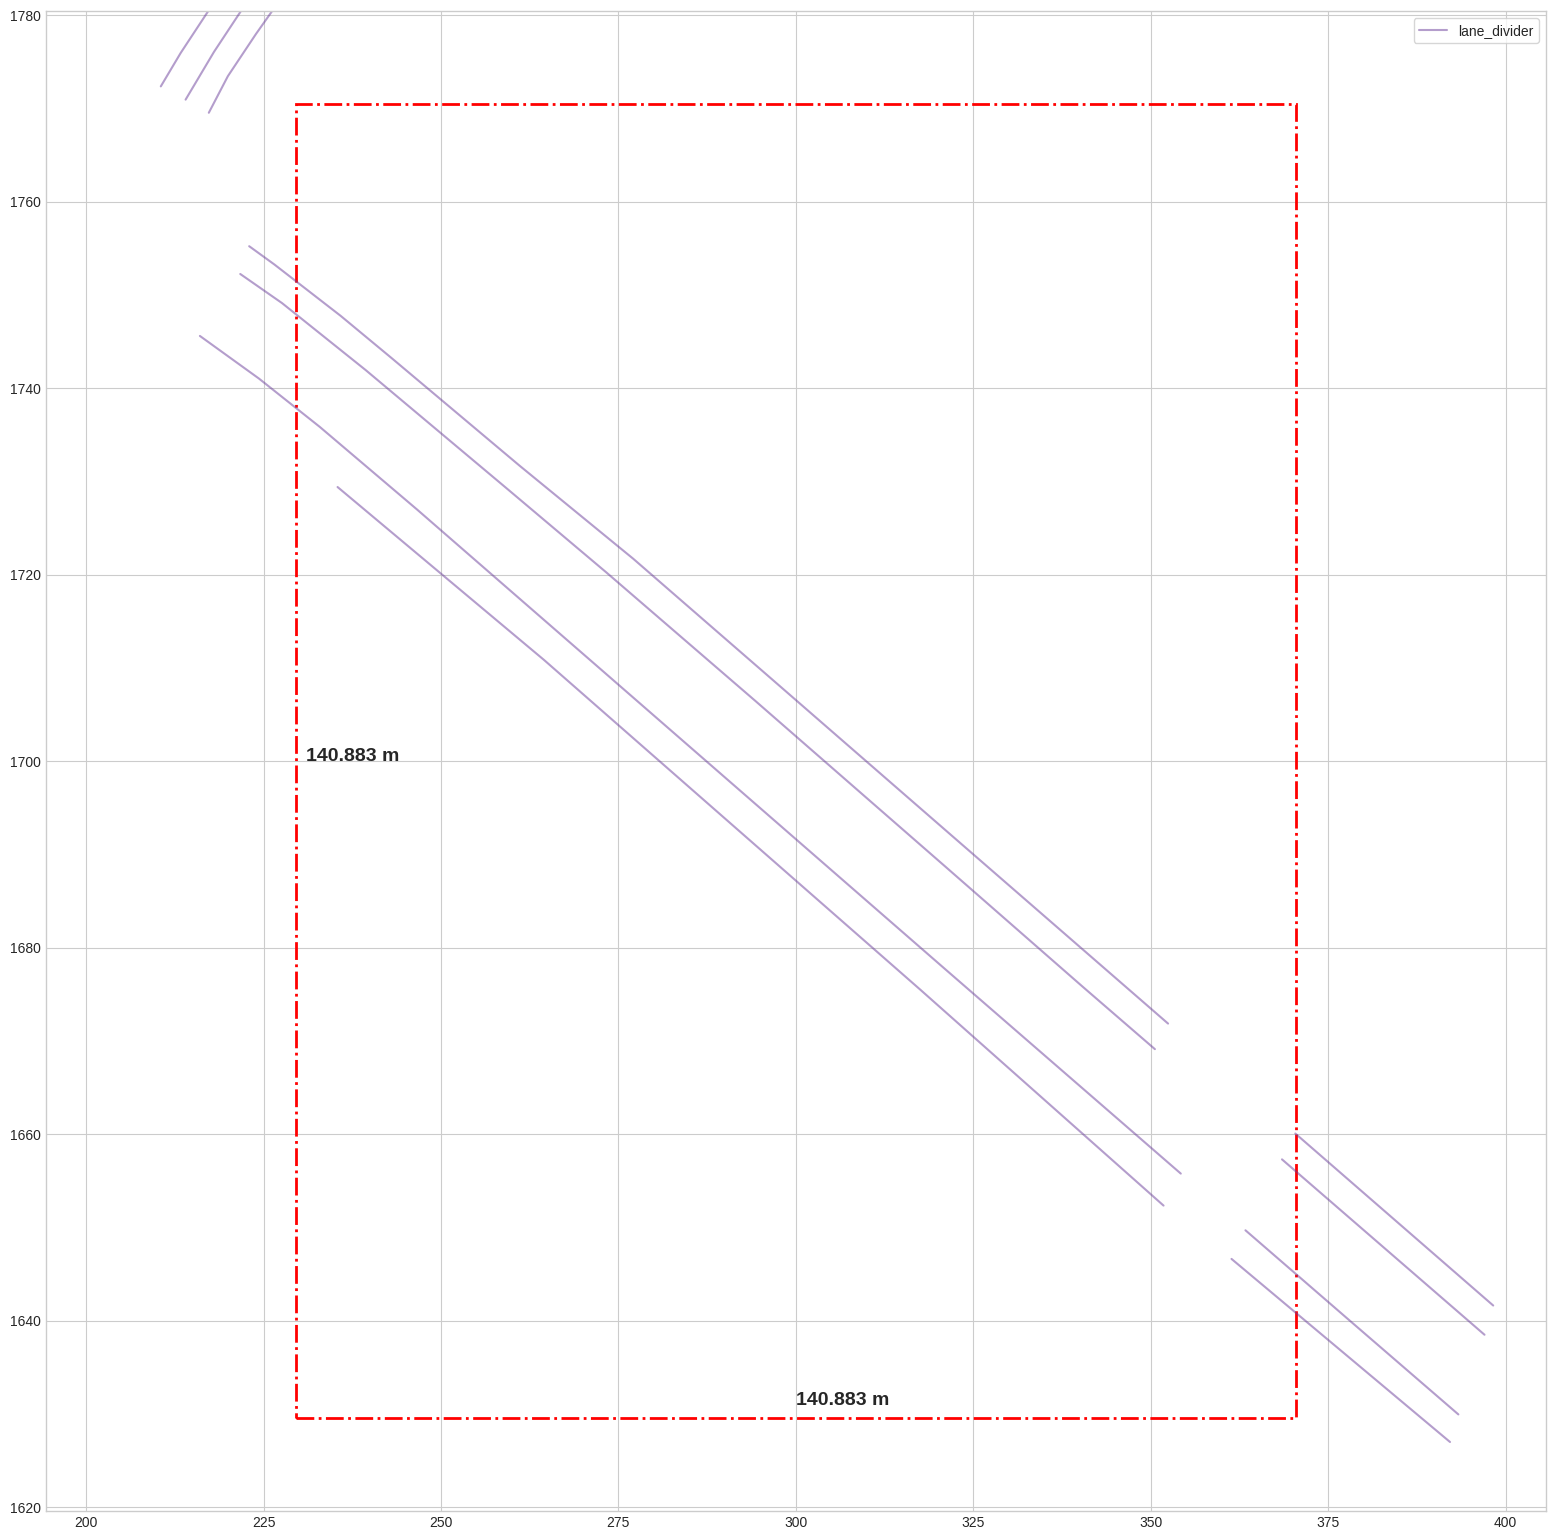

In [61]:
patch_box = (300, 1700, 100, 100)
patch_angle = 40  # Default orientation where North is up
layer_names = ['lane_divider']
canvas_size = (1000, 1000)

figsize = (12, 4)
fig, ax = nusc_map.render_map_mask(patch_box, patch_angle, layer_names, canvas_size, figsize=figsize, n_row=1)

patch = nusc_exp.get_patch_coord(patch_box, patch_angle)
minx, miny, maxx, maxy = patch.bounds
fig, ax = nusc_map.render_map_patch( [minx, miny, maxx, maxy], ['lane_divider'])


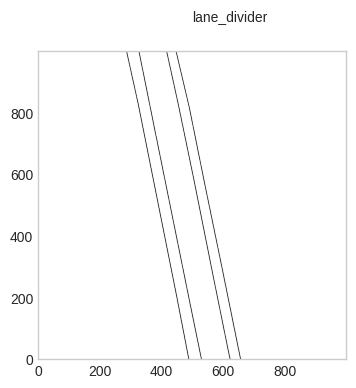

In [42]:
patch_angle = 45
map_mask = nusc_map.get_map_mask(patch_box, patch_angle, layer_names, canvas_size)
figsize = (12, 4)
fig, ax = nusc_map.render_map_mask(patch_box, patch_angle, layer_names, canvas_size, figsize=figsize, n_row=1)
